#### Notebook Imports

In [24]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True)
#import cufflinks as cf
#cf.go_offline()

%matplotlib inline

### Data Scrubbing and Organizing

In [25]:
#import CSV from project github

covid19Dataframe = pd.read_csv("https://raw.githubusercontent.com/WhipSnake23/Python-Class-Project/main/Data/owid-covid-data.csv")

#scrub data from rolled up rows for each region globally. NOTE: ~=="not"
covid19Dataframe = covid19Dataframe[~covid19Dataframe.iso_code.str.contains("OWID")]

#Create a date field for Day, Month, Year to help with Data aggregation.
covid19Dataframe.insert(59,'Day',pd.to_datetime(covid19Dataframe['date']),True)
covid19Dataframe.insert(60,'Month',pd.to_datetime(covid19Dataframe['date']),True)
covid19Dataframe.insert(61,'Year',pd.to_datetime(covid19Dataframe['date']),True)
covid19Dataframe.insert(62,'Year_Month',pd.to_datetime(covid19Dataframe['date']),True)
covid19Dataframe['Day'] = covid19Dataframe['Day'].dt.day
covid19Dataframe['Month'] = covid19Dataframe['Month'].dt.month
covid19Dataframe['Year'] = covid19Dataframe['Year'].dt.year
#create a column that is the first date of every month for every row. Used in group by statements
covid19Dataframe['Year_Month'] = pd.to_datetime(covid19Dataframe['Year'].astype(str) + '-' + covid19Dataframe['Month'].astype(str) + '-' +'01')
#Convert Date Column to Date and Time - NOTE: This may not be needed
covid19Dataframe['date'] = pd.to_datetime(covid19Dataframe['date'])
#Set Positivity Rate to an actual percentage
covid19Dataframe['positive_rate'] = covid19Dataframe['positive_rate'] * 100

## Notebook Functions

In [26]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

### Total Deaths in Mexico

In [27]:
#This function converts the axis into millions so that the chart scale is better


#Create a data frame that only has Mexico data
covid19DataframeMexico = covid19Dataframe[covid19Dataframe["iso_code"]=="MEX"]
#Group the data by month
covid19DataframeMexicoGrouped = covid19DataframeMexico.groupby(['Year_Month'], as_index=False)['total_deaths'].sum()
#reset the index
covid19DataframeMexicoGrouped.reset_index()

,index,Year_Month,total_deaths
0,0,2020-01-01,0.0
1,1,2020-02-01,0.0
2,2,2020-03-01,136.0
3,3,2020-04-01,19390.0
4,4,2020-05-01,165485.0
5,5,2020-06-01,562682.0
6,6,2020-07-01,1164238.0
7,7,2020-08-01,1749213.0
8,8,2020-09-01,2150492.0
9,9,2020-10-01,2649132.0


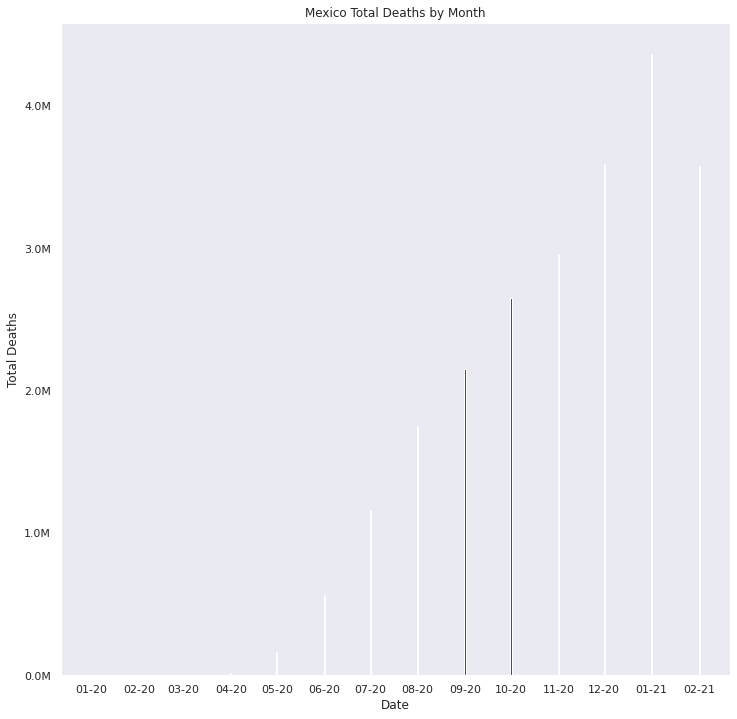

In [28]:
#Source: https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/

# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis from the data frame
ax.bar(covid19DataframeMexicoGrouped['Year_Month'],
       covid19DataframeMexicoGrouped['total_deaths'],
       color='red')

# Set title and labels for axis
ax.set(xlabel="Date",
       ylabel="Total Deaths",
       title="Mexico Total Deaths by Month")

# Define the date format
date_form = DateFormatter("%m-%y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator())

#Format the y axis ticks
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)

ax.grid(False)

#Render the chart
plt.show()

### Total Deaths vs the Top 20 countries with the highest Median Age

In [29]:
##This code block will filter the data and get the top n of a column
countries = covid19Dataframe[['iso_code','median_age']]
countries = countries.drop_duplicates()
top20Countries_MedianAge = countries.nlargest(20,'median_age')
top20Countries_list = top20Countries_MedianAge['iso_code'].values.tolist()
booleanSeries = covid19Dataframe.iso_code.isin(top20Countries_list)
top20Countries_MedianAge = covid19Dataframe[booleanSeries]


top20Countries_MedianAge = top20Countries_MedianAge[['location','date','total_deaths','median_age']]
#This gets one row per location to get the most recent row which has Total Deaths
##Needs work for Null Values
top20Countries_MedianAge = top20Countries_MedianAge[top20Countries_MedianAge.groupby('location').date.transform('max') == top20Countries_MedianAge['date']]

Text(0.5, 1.0, 'Total Deaths vs Top 20 Countries with the Highest Median Age')

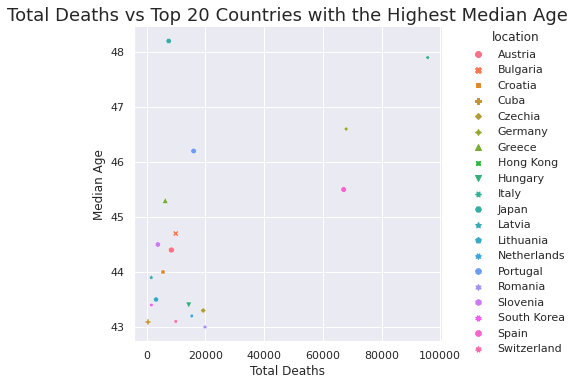

In [30]:
sns.set_theme()

# Create a visualization
sns.relplot(
    data=top20Countries_MedianAge,
    x="total_deaths", y="median_age",
    hue="location", style="location",
)
#plt.figure(figsize=(10,6))
plt.xlabel("Total Deaths")
plt.ylabel("Median Age")
plt.title("Total Deaths vs Top 20 Countries with the Highest Median Age", size=18)

### Total Deaths vs the Top 20 countries with the highest population density

In [31]:
countries = covid19Dataframe[['iso_code','population_density']]
countries = countries.drop_duplicates()
top20Countries_PopD = countries.nlargest(20,'population_density')
top20Countries_list = top20Countries_PopD['iso_code'].values.tolist()
booleanSeries = covid19Dataframe.iso_code.isin(top20Countries_list)
top20Countries_PopD = covid19Dataframe[booleanSeries]
top20Countries_PopD = top20Countries_PopD[['location','date','total_deaths','population_density']]
top20Countries_PopD = top20Countries_PopD[top20Countries_PopD.groupby('location').date.transform('max') == top20Countries_PopD['date']]


In [32]:
fig = px.scatter(top20Countries_PopD, x="total_deaths", y="population_density", color="location",
                 title="Total Deaths vs Top 20 Countries with the Highest Population Density",
                 labels={
                     "total_deaths" : "Total Deaths",
                    "population_density" : "Population Density",
                     "location" : "Country"
                    } #Labels are customized using the above dictionary type configuration
                )

fig.show()

### Italy's Positivity Rate

In [33]:
covid19DataframeItaly = covid19Dataframe[covid19Dataframe["iso_code"]=="ITA"]
covid19DataframeItalyGrouped = covid19DataframeItaly.groupby(['Year_Month'], as_index=False)['positive_rate'].mean()
covid19DataframeItalyGrouped.sort_values(by=['Year_Month'])
fig = px.line(covid19DataframeItalyGrouped, x="Year_Month", y="positive_rate", title='Italy Positivty Rate',  labels={
                  "positive_rate" : "Total Deaths",
                "Year_Month" : "Month"
               } )
fig.show()

### Asia Region Focus

In [34]:
# Filter dataframe to only include Asian countries on February 21, 2021
februaryAsia = covid19Dataframe[covid19Dataframe["continent"] == 'Asia']
februaryAsia = februaryAsia[februaryAsia["Year"] == 2021]
februaryAsia = februaryAsia[februaryAsia["Month"] == 2]
februaryAsia = februaryAsia[februaryAsia["Day"] == 21]

In [35]:
# Filter out the top 5 highest new case counts in Asian countries for February 21, 2021
top5Countries_newcases = februaryAsia.nlargest(5,'new_cases')
top5Countries_newcases

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Day,Month,Year,Year_Month
29311,IND,Asia,India,2021-02-21,11005850.0,14199.0,12751.571,156385.0,83.0,93.286,...,1.9,20.6,59.550,0.53,69.66,0.645,21,2,2021,2021-02-01
30418,IRN,Asia,Iran,2021-02-21,1574012.0,7931.0,7964.143,59483.0,74.0,76.857,...,0.8,21.1,NaN,1.50,76.68,0.783,21,2,2021,2021-02-01
29668,IDN,Asia,Indonesia,2021-02-21,1278653.0,7300.0,8740.714,34489.0,173.0,186.571,...,2.8,76.1,64.204,1.04,71.72,0.718,21,2,2021,2021-02-01
65261,TUR,Asia,Turkey,2021-02-21,2638422.0,6546.0,7462.714,28060.0,77.0,84.143,...,14.1,41.1,NaN,2.81,77.69,0.820,21,2,2021,2021-02-01
31541,ISR,Asia,Israel,2021-02-21,750043.0,5530.0,3666.143,5577.0,51.0,27.000,...,15.4,35.4,NaN,2.99,82.97,0.919,21,2,2021,2021-02-01


In [36]:
# Top 5 new case counts
asiaNewCases = top5Countries_newcases["new_cases"]
asiaNewCases

29311    14199.0
30418     7931.0
29668     7300.0
65261     6546.0
31541     5530.0
Name: new_cases, dtype: float64

In [37]:
# Top 5 new case countries
asiaTop5 = top5Countries_newcases["location"]
asiaTop5

29311        India
30418         Iran
29668    Indonesia
65261       Turkey
31541       Israel
Name: location, dtype: object

### A look at new cases in Asian Countries on Febuary 21st in Three different Charts

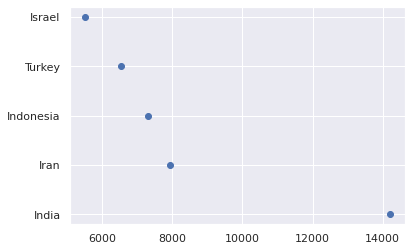

In [38]:
# Using Matplotlib to generate a scatter plot for top 5 largest new cases in Asia
plt.scatter(asiaNewCases,asiaTop5)

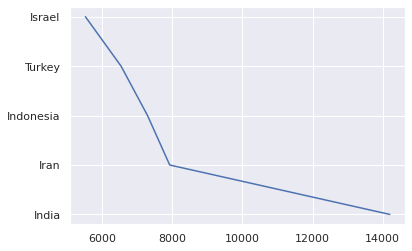

In [39]:
# Using Matplotlib to generate a line plot for top 5 largest new cases in Asia
plt.plot(asiaNewCases,asiaTop5)

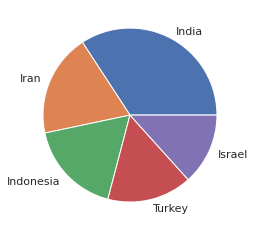

In [40]:
# Using Matplotlib to generate a pie chart with labels
pie = plt.pie(asiaNewCases, labels=asiaTop5)


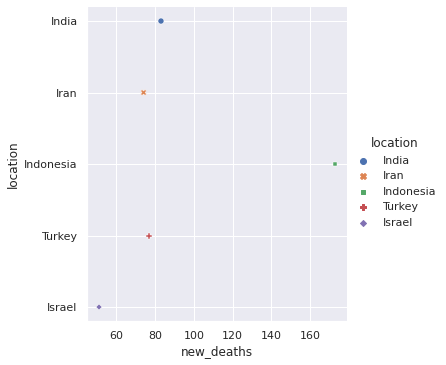

In [41]:
# Use Seaborn to create plot graph
sns.set_theme()

# Create a visualization
sns.relplot(
    data=top5Countries_newcases,
    x="new_deaths", y="location",
    hue="location", style="location",
)

In [42]:
# Using plotly to display February, 21 2021 new cases in Asia
fig = px.bar(februaryAsia, x='location', y='new_cases', color='location', title='February 21, 2021 New Cases in Asia')
fig.show()

In [43]:
#Create a data frame that only has North America data
covid19DataframeNorthAmerica = (covid19Dataframe[covid19Dataframe["continent"]=="North America"]).copy()
covid19DataframeNorthAmerica.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Day,Month,Year,Year_Month
2161,AIA,North America,Anguilla,2021-02-04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.88,NaN,4,2,2021,2021-02-01
2162,AIA,North America,Anguilla,2021-02-05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.88,NaN,5,2,2021,2021-02-01
2163,AIA,North America,Anguilla,2021-02-06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.88,NaN,6,2,2021,2021-02-01
2164,AIA,North America,Anguilla,2021-02-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.88,NaN,7,2,2021,2021-02-01
2165,AIA,North America,Anguilla,2021-02-08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.88,NaN,8,2,2021,2021-02-01


<AxesSubplot:>

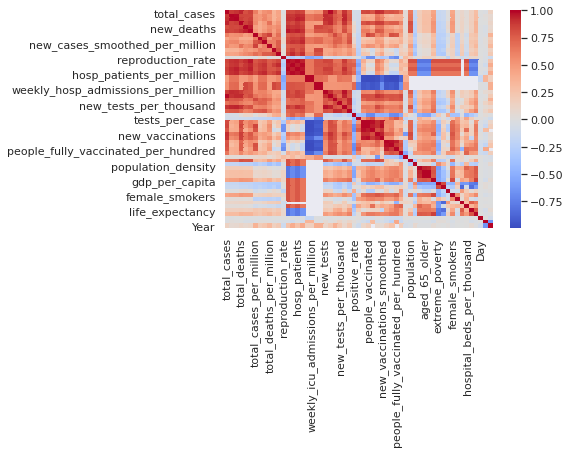

In [44]:
sns.heatmap(covid19DataframeNorthAmerica.corr(),cmap='coolwarm')

In [45]:
#Choropleth World Map - Death Count
data = dict(
type = 'choropleth',
colorscale = 'Viridis',
reversescale = True,
locations = covid19Dataframe['location'],
locationmode = "country names",
z = covid19Dataframe['total_deaths_per_million'],
text = covid19Dataframe['location'],
colorbar = {'title' : 'total_deaths_per_million'},
)
layout = dict(title = 'Total Deaths Per Million',
geo = dict(showframe = False,projection = {'type':'mercator'})
              )
choromap = go.Figure(data = [data],layout = layout)
plot(choromap,validate=False)

'temp-plot.html'

In [46]:
#Spread Plot visual of total cases to total death count.
#covid19Dataframe[['total_deaths','total_cases']].iplot(kind='spread')


In [47]:
Country1 = "USA"
Country2 = "BRA"
Country3 = "MEX"
Country4 = "IND"
Country5 = "GBR"


In [48]:
#covid19Data = pd.read_csv("https://raw.githubusercontent.com/WhipSnake23/Python-Class-Project/main/Data/owid-covid-data.csv")

covid19DataCountry1= covid19Dataframe[(covid19Dataframe["iso_code"] == Country1)]
covid19DataCountry2= covid19Dataframe[(covid19Dataframe["iso_code"] == Country2)]
covid19DataCountry3= covid19Dataframe[(covid19Dataframe["iso_code"] == Country3)]
covid19DataCountry4= covid19Dataframe[(covid19Dataframe["iso_code"] == Country4)]
covid19DataCountry5= covid19Dataframe[(covid19Dataframe["iso_code"] == Country5)]

covid19DataCountry1.insert(0,'YearMonth',pd.to_datetime(covid19DataCountry1['date']).dt.to_period('M'))
covid19DataCountry2.insert(0,'YearMonth',pd.to_datetime(covid19DataCountry2['date']).dt.to_period('M'))
covid19DataCountry3.insert(0,'YearMonth',pd.to_datetime(covid19DataCountry3['date']).dt.to_period('M'))
covid19DataCountry4.insert(0,'YearMonth',pd.to_datetime(covid19DataCountry4['date']).dt.to_period('M'))
covid19DataCountry5.insert(0,'YearMonth',pd.to_datetime(covid19DataCountry5['date']).dt.to_period('M'))

country1Deaths=covid19DataCountry1.groupby(['YearMonth'], as_index=False).agg(total_deaths1=('total_deaths', sum))
country2Deaths=covid19DataCountry2.groupby(['YearMonth'], as_index=False).agg(total_deaths2=('total_deaths', sum))
country3Deaths=covid19DataCountry3.groupby(['YearMonth'], as_index=False).agg(total_deaths3=('total_deaths', sum))
country4Deaths=covid19DataCountry4.groupby(['YearMonth'], as_index=False).agg(total_deaths4=('total_deaths', sum))
country5Deaths=covid19DataCountry5.groupby(['YearMonth'], as_index=False).agg(total_deaths5=('total_deaths', sum))

deathsByPeriod = pd.concat([country1Deaths['YearMonth'], country1Deaths['total_deaths1'], country2Deaths['total_deaths2'], country3Deaths['total_deaths3']
                                                         ,country4Deaths['total_deaths4'], country5Deaths['total_deaths5']
                              ], axis=1,join='outer')

print(f"{deathsByPeriod}")




   YearMonth  total_deaths1  total_deaths2  total_deaths3  total_deaths4  \
0    2020-01            0.0            0.0            0.0            0.0   
1    2020-02            1.0          976.0            0.0            0.0   
2    2020-03        25738.0        66571.0          136.0          226.0   
3    2020-04      1070749.0       509030.0        19390.0        14417.0   
4    2020-05      2805562.0      1353392.0       165485.0        94154.0   
5    2020-06      3582409.0      2370476.0       562682.0       331856.0   
6    2020-07      4339173.0      3345405.0      1164238.0       812555.0   
7    2020-08      5281969.0      4004352.0      1749213.0      1582152.0   
8    2020-09      5902414.0      4732789.0      2150492.0      2476764.0   
9    2020-10      6812467.0      4986319.0      2649132.0      3481048.0   
10   2020-11      7522620.0      5702548.0      2962546.0      3909675.0   
11   2020-12      9696730.0      6483686.0      3594393.0      4468495.0   
12   2021-01

In [49]:
deathsByPeriod['total_deaths1'] = deathsByPeriod['total_deaths1'].div(1000).round(0)
deathsByPeriod['total_deaths2'] = deathsByPeriod['total_deaths2'].div(1000).round(0)
deathsByPeriod['total_deaths3'] = deathsByPeriod['total_deaths3'].div(1000).round(0)
deathsByPeriod['total_deaths4'] = deathsByPeriod['total_deaths4'].div(1000).round(0)
deathsByPeriod['total_deaths5'] = deathsByPeriod['total_deaths5'].div(1000).round(0)

In [50]:
bars1 = deathsByPeriod['total_deaths1'][:12]
bars2 = deathsByPeriod['total_deaths2'][:12]
bars3 = deathsByPeriod['total_deaths3'][:12]
bars4 = deathsByPeriod['total_deaths4'][:12]
bars5 = deathsByPeriod['total_deaths5'][:12]

In [51]:
names = deathsByPeriod['YearMonth'][:12]
#print(f"{names}")

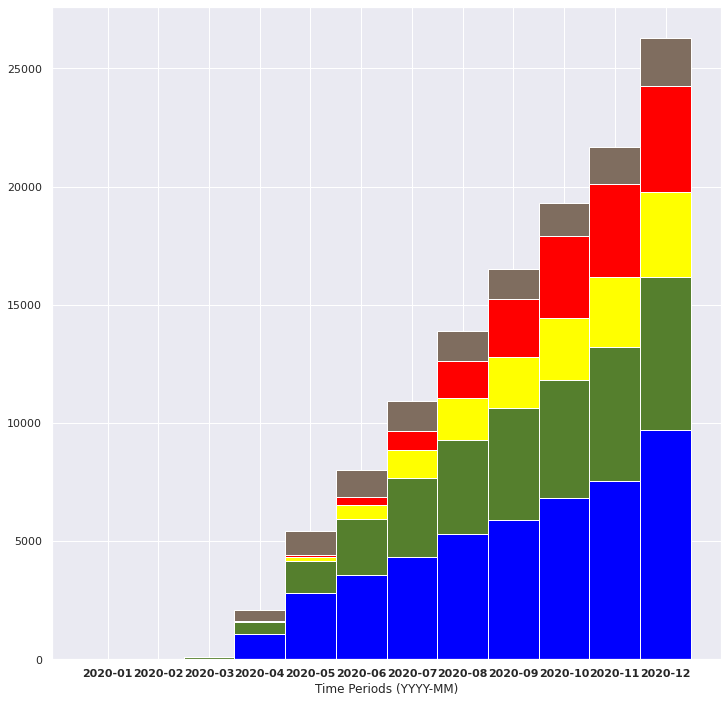

In [52]:
barWidth = 1
bars12 = np.add(bars1, bars2).tolist()
bars123 = np.add(bars12, bars3).tolist()
bars1234 = np.add(bars123, bars4).tolist()
p = [0,1,2,3,4,5,6,7,8,9,10,11] # bar position on x-axis
plt.subplots(figsize=(12, 12))
plt.bar(p, bars1, color='#0000ff', edgecolor='white', width=barWidth)
plt.bar(p, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=barWidth)
plt.bar(p, bars3, bottom=bars12, color='#ffff00', edgecolor='white', width=barWidth)
plt.bar(p, bars4, bottom=bars123, color='#ff0000', edgecolor='white', width=barWidth)
plt.bar(p, bars5, bottom=bars1234, color='#7f6d5f', edgecolor='white', width=barWidth)


# Custom X axis
plt.xticks(p, names, fontweight='bold')
plt.xlabel("Time Periods (YYYY-MM)")

plt.show()

array([[<AxesSubplot:title={'center':'Deaths in USA (1000s)'}>,
        <AxesSubplot:title={'center':'Deaths in BRA (1000s)'}>],
       [<AxesSubplot:title={'center':'Deaths in MEX (1000s)'}>,
        <AxesSubplot:title={'center':'Deaths in IND (1000s)'}>]],
      dtype=object)

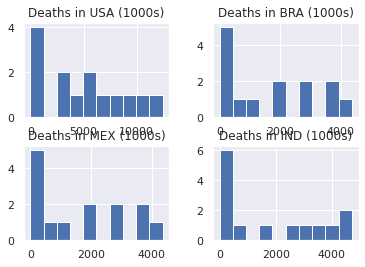

In [53]:
#plt.subplots(figsize=(12,12))
histrogramOfDeaths = pd.DataFrame({
    'Deaths in USA (1000s)' : deathsByPeriod['total_deaths1'],
    'Deaths in BRA (1000s)': deathsByPeriod['total_deaths3'],
    'Deaths in MEX (1000s)': deathsByPeriod['total_deaths3'],
    'Deaths in IND (1000s)': deathsByPeriod['total_deaths4']
    })

histrogramOfDeaths.hist()


(array([[4., 0., 2., 1., 2., 1., 1., 1., 1., 1.],
        [4., 2., 1., 3., 2., 1., 0., 0., 0., 0.],
        [7., 2., 4., 1., 0., 0., 0., 0., 0., 0.],
        [7., 2., 2., 3., 0., 0., 0., 0., 0., 0.]]),
 array([    0. ,  1243.2,  2486.4,  3729.6,  4972.8,  6216. ,  7459.2,
         8702.4,  9945.6, 11188.8, 12432. ]),
 <a list of 4 BarContainer objects>)

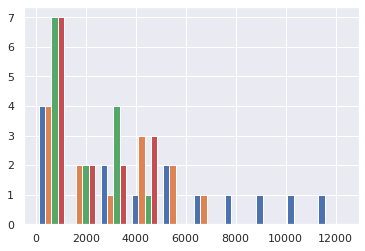

In [54]:
plt.hist([deathsByPeriod['total_deaths1'],
          deathsByPeriod['total_deaths2'],
          deathsByPeriod['total_deaths3'],
          deathsByPeriod['total_deaths4']
         ])

(array([4., 0., 1., 1., 0., 1., 1., 3., 1., 1.]),
 array([   0. ,  648.4, 1296.8, 1945.2, 2593.6, 3242. , 3890.4, 4538.8,
        5187.2, 5835.6, 6484. ]),
 <BarContainer object of 10 artists>)

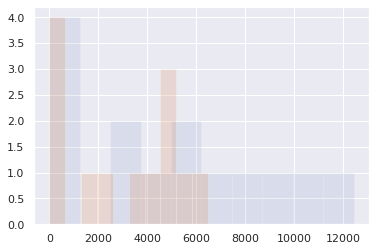

In [55]:
plt.hist(deathsByPeriod['total_deaths1'], alpha=0.1)
plt.hist(deathsByPeriod['total_deaths2'], alpha=0.2)


